# Mass-radius calculations

## Package setup

In [1]:
using Ogre
using WaterData
using DataFrames
using PyPlot
using PyCall

## Seager et al 2007

We check whether we can reproduce the mass-radius diagrams by Seager et al (2007) using their EOS - if so, this is an indication that our integrator is working correctly.

### EOS

In [2]:
# WaterData contains the EOSes used by Seager et al in that paper
eoses = WaterData.load_piecewise_eoses()

Dict{ByteString,Any} with 3 entries:
  "h2o"    => WaterData.LineEOS([100000.0,1.9307e5,3.72759e5,7.19686e5,1.3895e6…
  "fe"     => WaterData.LineEOS([100000.0,1.9307e5,3.72759e5,7.19686e5,1.3895e6…
  "mgsio3" => WaterData.LineEOS([100000.0,1.9307e5,3.72759e5,7.19686e5,1.3895e6…

In [3]:
# Fe, ϵ phase, Vinet at low pressures then TFD at high temperatures
fe = eoses["fe"]
# MgSiO3 perovskite, 4th order BME at low pressures then ditto
mgsio3 = eoses["mgsio3"]
# H2O, ice VII, 3rd order BME then density function theory
# calculations then TFD at high pressures
h2o = eoses["h2o"];

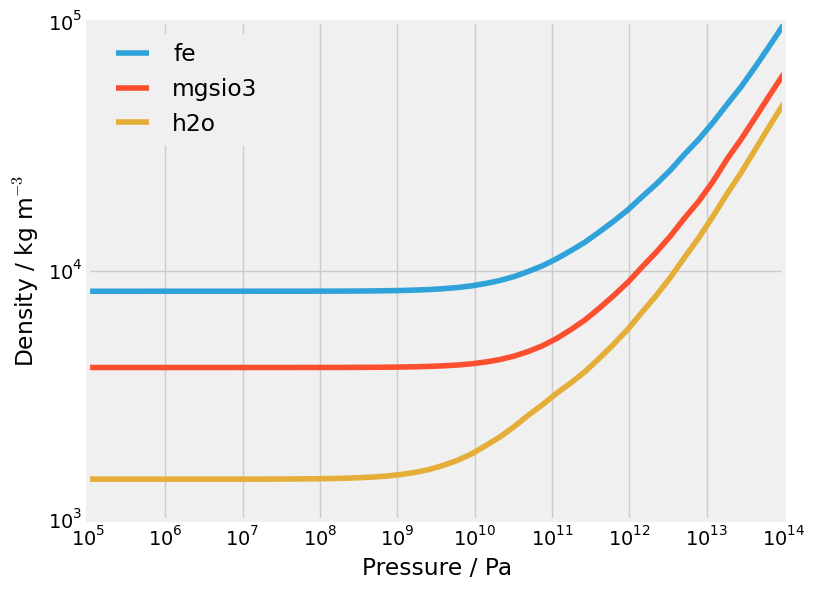

PyObject <matplotlib.legend.Legend object at 0x7f9f98f7c550>

In [4]:
# let's have a look at them
P = logspace(5,14)
for eos in (:fe, :mgsio3, :h2o)
    @eval ρ = map($eos, P)
    plot(P, ρ, label=eos)
end

xscale("log")
yscale("log")
xlabel("Pressure / Pa")
ylabel(L"Density / kg m$^{-3}$")
legend(loc=:best)

### Planet integrator setup

In [5]:
# the starting pressure is pretty arbitrary since the EOS is constant with
# pressure to ~ 1 GPa - Seager use a boundary condition of 0 so let's pick 
# a meagre 1 Pa
Psurf = 1    # Pa

Rguess = R_earth
Rbracket = [0, 3Rguess]
Npoints = 200;

In [6]:
"Get the radius of an isothermal planet of mass M using a given EOS"
function R_isothermal(M, eos)
    boundary_vals = Ogre.ValueSet(M, Rguess, Psurf)
    grid = linspace(M, 0, Npoints)
    planet = Ogre.PlanetSystem(M, eos, boundary_vals, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end;

### MR curve and export

In [7]:
masses = linspace(0.5M_earth, 10M_earth, 30)
results = Dict()
for eos in (:h2o, :mgsio3, :fe)
    @eval radii = map(m -> R_isothermal(m, $eos), masses)
    m = masses/M_earth
    r = radii/R_earth
    df = DataFrame(mass=m, radius=r)
    writetable("massradius/mine/seager2007/$eos.csv", df)
end

## Valencia et al 2007

We compare our models to an Earth-like model as produced by Valencia et al in their 2007 paper "Detailed Models of Super-Earths [...]".

In Figure 3 of that paper, they have a mass-radius relationship for terrestrial planets with various water layers. We will make some simple models with isothermal cores/mantles and then water layers on top to see how this compares.
We expect the dry planet (no water layer) to be pretty similar, with maybe some small differences because we are using simple isothermal EOSes taken from Seager et al (2007) for the iron and MgSiO3 phases. As far as I can tell, Valencia's 2007 paper only uses the ice VII EOS for water, so we expect bigger differences when we stack the water layer on top, since I have a more complete EOS.

I wanted to compare to a similar model in Valencia et al 2013, "Bulk composition of GJ 1214b [...]", this time with a H2O envelope which used an atmospheric code. They find significantly inflated radii here, so it would be interesting to see how our results compare, especially since they switched to a more complete EOS treatment. But I couldn't directly make this comparison because of the atmospheric aspect to it - our model does interiors, so it doesn't handle anything less than about 1 bar, and they have a more complicated model which handles an atmosphere. I wanted to show evidence of a large inflated radius due to temperature effects in the low-density water layer, but I chose to compare to a plot from Lopez et al to show this instead (below).

### EOS

In [8]:
# We'll use the simple EOSes from above + our full H2O EOS for the water layer
core_eos = fe
mantle_eos = mgsio3
full_h2o_eos = WaterData.load_full_eos()["grid"]

# Use the tabulated H2O heat capacity
Cₚ = Ogre.GridHeatCapacity("$(Ogre.config.datadir)/tabulated/heatcap-h2o.dat")

Psurf_hi = 1e10  # Pa
Psurf_med = 1e7  # Pa
Psurf_lo = 1e4   # Pa
Rguess = R_earth
Rbracket = [0, 10Rguess]
Npoints = 200;

### Planet integrator setup

In [9]:
"Get the radius of a multilayer iron/silicate/water layer planet"
function R_adiabat_cored(M, h2ofrac, Psurf, Tsurf)
    # do a simpler isothermal calculation if there's no water layer
    if h2ofrac == 0
        return R_isotherm_nowater(M, Psurf)
    end
    
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf, Tsurf)
    grid = linspace(M, 0, Npoints)
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    mantlecorefrac = 1 - h2ofrac
    corefrac = 1/3 * mantlecorefrac
    mantlefrac = 2 * corefrac
    massfracs = [corefrac, mantlefrac, h2ofrac]
    @assert sum(massfracs) ≈ 1
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [core_eos, mantle_eos, full_h2o_eos]
    coredeos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, coredeos, Cₚ, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end

"Get the radius of an iron/silicate planet"
function R_isotherm_nowater(M, Psurf)
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf)
    grid = linspace(M, 0, Npoints)
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    massfracs = [1/3, 2/3]
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [core_eos, mantle_eos]
    eos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, eos, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end;

In [10]:
# Sanity check: do we get roughly R⊕ when we use a M⊕ sized planet as input?
# Do we find that the planet is bigger if we replace some of it with water?

# 0% water, 33% Fe, 66% MgSiO3
@show R_adiabat_cored(M_earth, 0, Psurf_hi, 300) / R_earth 

# 50% water
@show R_adiabat_cored(M_earth, 0.5, Psurf_hi, 300) / R_earth;

R_adiabat_cored(M_earth,0,Psurf_hi,300) / R_earth = 0.9606803953647614

  likely near In[10]:127
  likely near In[10]:127
  likely near In[10]:127



R_adiabat_cored(M_earth,0.5,Psurf_hi,300) / R_earth = 1.1751540005207062

### MR curves and export

In [11]:
# Make mass-radius relations for planets without and with water layers
using ProgressMeter
    
nmasses = 30
Mgrid = linspace(0.5M_earth, 10M_earth, nmasses)

"Make and save a M-R diagram for a given temp/pressure/water fraction"
function makemr!(name, Psurf, T, h2ofrac)
    m = Mgrid/M_earth
    p = Progress(nmasses)
    r = map(Mgrid) do M
        next!(p)
        R_adiabat_cored(M, h2ofrac, Psurf, T) / R_earth
    end
    df = DataFrame(mass=m, radius=r)
    writetable("massradius/$name.csv", df)
end

makemr!("mine/valencia2007/dry", 1e10, 550, 0)
makemr!("mine/valencia2007/wet_1e10Pa", 1e10, 550, 0.5)
makemr!("mine/valencia2007/wet_1e7Pa", 1e7, 550, 0.5)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


## Lopez et al 2012

This is the best paper I could find that shows the effect of an inflated water radius at high temperatures, so I thought it deserved a comparison. I could have sworn I saw another similar plot somewhere (by Nettelmann et al?) but I couldn't find it, so I'll compare to this paper instead.

In [12]:
# We'll let the core and mantle EOSes carry down from above - all we need to do
# is choose appropriate surface pressures and temperatures

makemr!("mine/lopez2012/dry", 1e7, 700, 0)
makemr!("mine/lopez2012/wet50", 1e7, 700, 0.5)
makemr!("mine/lopez2012/wet50_colder", 1e7, 500, 0.5)
makemr!("mine/lopez2012/wet50_hotter", 1e7, 900, 0.5)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
